# Exponential smoothing and Holt Winters

In [1]:
from calendar import month
from pathlib import Path
from dotenv import dotenv_values

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
DATA_DIR = Path("Exponential Smoothing and Holt Winters")
DATA_PATH = dotenv_values(Path.cwd().parent.parent / ".env")["TIMESERIES_ANALYSIS_DIR"] / DATA_DIR

In [3]:
# read data
df = pd.read_csv(DATA_PATH / "weekly_customer_complaints.csv", index_col="week", parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


## Data Preprocessing

In [4]:
# set index frequency
df = df.asfreq("W-Mon")
# guarantee right variable format
df["complaints"] = df["complaints"].str.replace(",", "").astype(float)

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

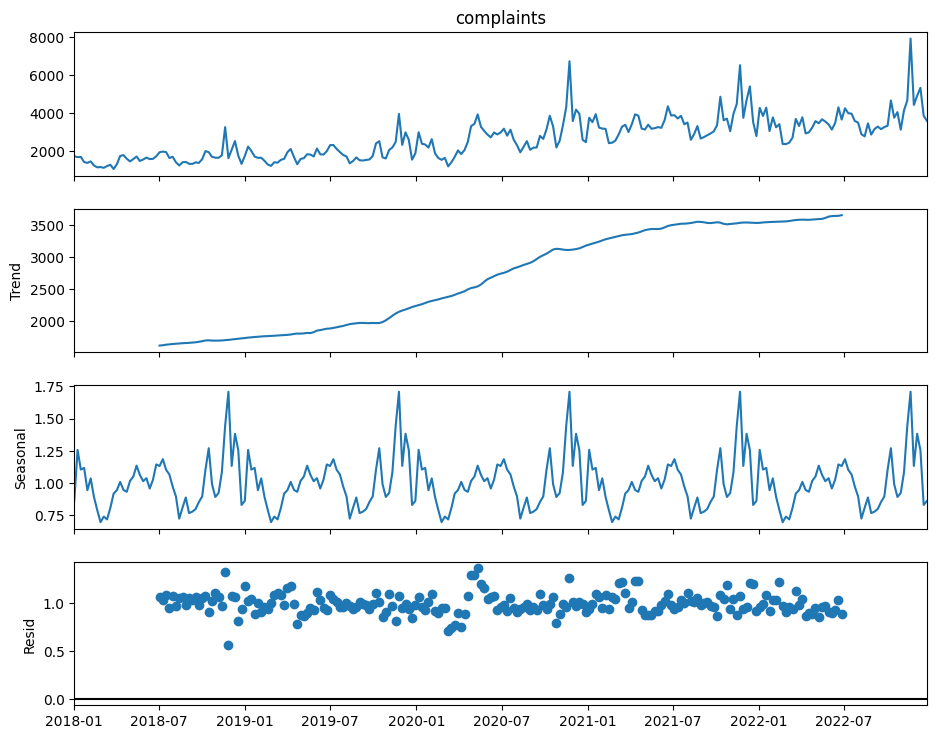

In [6]:
# seasonal decomposition plots
decomposition = seasonal_decompose(
    df["complaints"], # this must contain 2 complete cycles
    model="multiplicative", # if season is not evident, with multiplicative could have more sense
    period=52 # for weekly
)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

Spikes on Nov usually and valleys on Feb-Mar.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

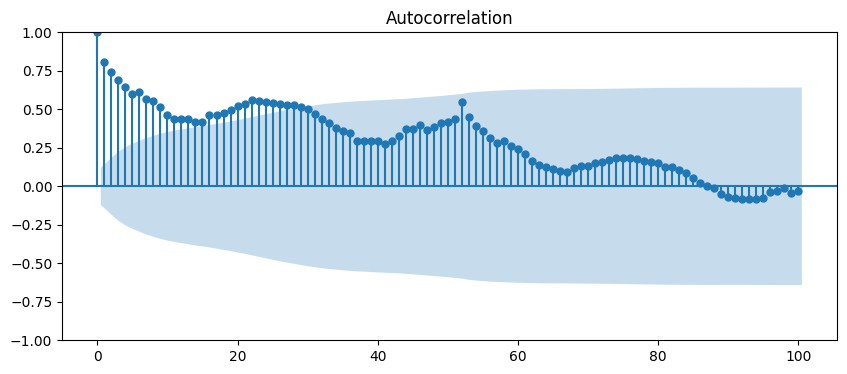

In [8]:
# plot the auto-correlation (acf)
_, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["complaints"], lags=100, ax=ax)
plt.show()

Recent data seems like a good assest to use, and the spike on lag 52 as well.

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

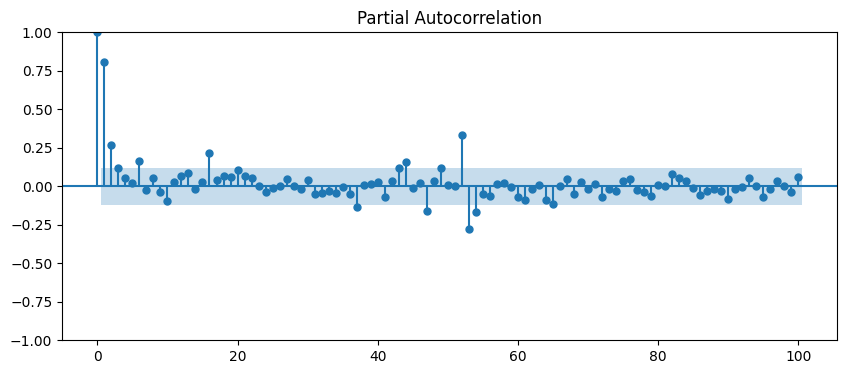

In [10]:
# plot the auto-correlation (acf)
_, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df["complaints"], lags=100, ax=ax)
plt.show()


So to confirm, the real relation could be with lag 1-2 and lag 52-53 definitely.